In [13]:
import os
import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf


In [2]:
path_csv = "datasets/MSFT_3M_Daily.csv"

df = pd.read_csv(path_csv)

date_time = pd.to_datetime(df.pop('Date'), format='%Y-%m-%d')

In [3]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
0,378.000000,379.790009,374.970001,377.850006,377.152557,23345300
1,377.329987,377.970001,375.140015,377.429993,376.733307,10176600
2,376.779999,380.640015,376.200012,378.609985,377.911133,22179200
3,378.350006,383.000000,378.160004,382.700012,381.993622,20453100
4,383.760010,384.299988,377.440002,378.850006,378.150696,28963400


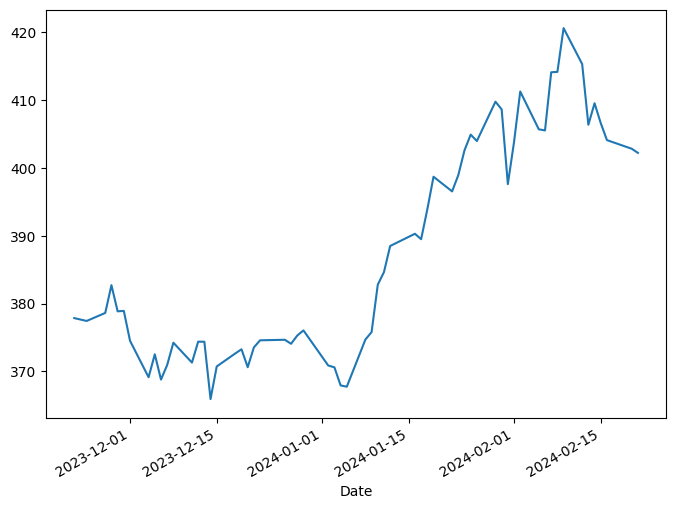

In [81]:
plot_features = df['Close']
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

Split data

In [4]:
c_ind = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

Normalize data

In [5]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df-train_mean) / train_std
val_df = (val_df-train_mean) / train_std
test_df = (val_df-train_mean) / train_std

Helpers to handle datasets

In [7]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],axis=-1)

        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels


    def plot(self, model=None, plot_col='Close', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

            plt.xlabel('Time [h]')

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32,)

        ds = ds.map(self.split_window)

        return ds


    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        result = getattr(self, '_example', None)
        if result is None:
            result = next(iter(self.train))
            self._example = result
        return result

    

Create dataset "windows"

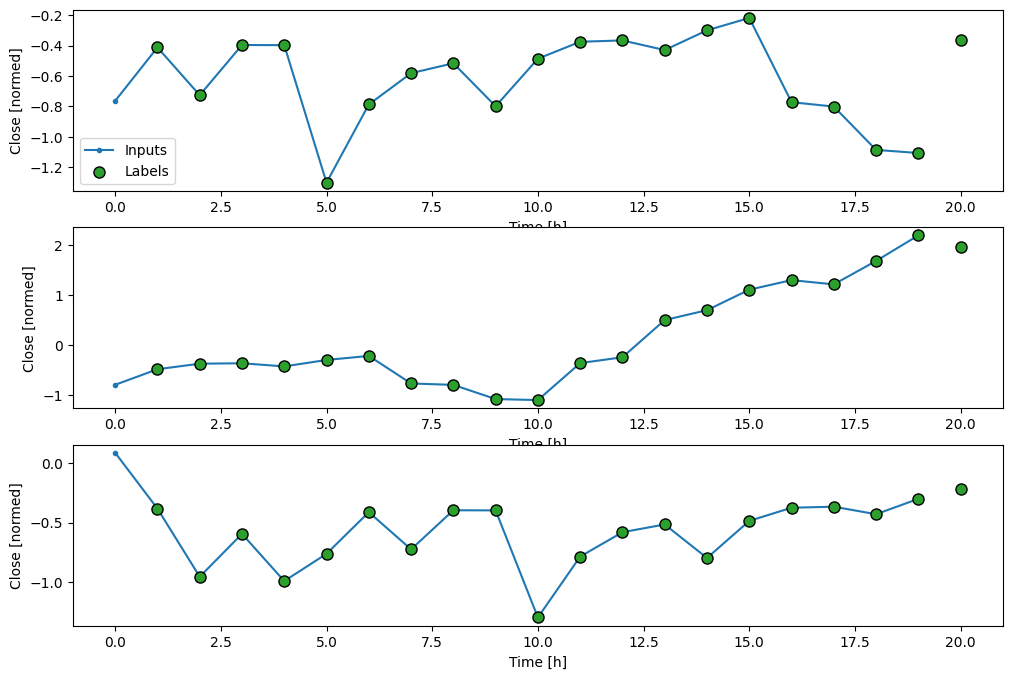

In [8]:
mv_window = WindowGenerator(
    input_width=20, label_width=20, shift=1,
    label_columns=['Close'])

mv_window.plot()

train_df_uv = pd.DataFrame(train_df['Close'])
test_df_uv = test_df['Close']
val_df_uv = val_df['Close']

uv_window = WindowGenerator(input_width=20, label_width=20, train_df=train_df_uv, test_df=test_df_uv, val_df=val_df_uv ,shift=1, label_columns=['Close'])


LSTM Model - Single preditction - Return sequences

In [11]:
lstm_ss_rs = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(16, return_sequences=True),
    tf.keras.layers.Dense(units=1)
])

LSTM Model - Single prediction

In [ ]:
lstm_ss = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(units=1)
])

LSTM Model - Multi preditction - Single Shot

In [24]:
out_steps = 10
lstm_mp_uv = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(out_steps,
                          kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([out_steps, 1])
])

lstm_mp_uv = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(out_steps,
                          kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([out_steps,1])                          
])


In [12]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=2,
                                                    mode='min')

lstm_ss_rs.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])

lstm_ss_rs.fit(mv_window.train, epochs=20, 
    validation_data = mv_window.val,
              callbacks=[early_stopping])

Epoch 1/20
1/1 [==============================] - ETA: 0s - loss: 0.6994 - mean_absolute_error: 0.7294

ValueError: Expected input data to be non-empty.